#Zadanie. Facial keypoints recignition (3punkty)

1. Wykorzystaj dane zamieszczone na teams. Załaduj dane i obejrzyj je. Zbiór danych ma 31 kolumn. Pierwsze 30 kolumn to współrzędne punktów kluczowych twarzy. Kolumna 31 to spłaszczony obraz o wymiarach 96x96 w skali szarości. Zadanie polega na rozpozanawaniu współrzędnych kluczowych punktów twarzy na zdjęciu.
(Przed załadowaniem pamiętaj o zamontowaniu dysku, jeśli pracujesz w Google Colab i przechowujesz dane na dysku)
2. Przygotuj dane. Zmień kształt tak, aby pasował do sieci konwulucyjej. Przeskaluj, jeśli to konieczne. Podziel dane na zestaw treningowy i testowy.
3. Utwórz model - użyj kilku warstw konwolucyjnych i max pooling. Ostatnia warstwa powinna być gęstą warstwą.
4. Dopasuj model. Użyj części zestawu treningowego do walidacji. Dodaj wywołania zwrotne, na przykład wcześniejsze zatrzymanie. Ustaw średni błąd bezwzględny(MAE) jako metrykę ewaluacji. Wykorzystaj błąd średniokwadratowy jako funkcję koszyu. Zapisz historię trenowania i narysuj wykresy funkcji straty dla zbioru treningowego i testowego. Spróbuj znaleźć takie hiperparametry, aby osiągnąć 7,0 MAE lub mniej na zbiorze walidacyjnym.
5. Po znalezieniu najlepszego modelu użyj tego modelu na danych testowych. Czy  wyniki są podobne jak na walidacyjnym?
6. Zwizualizuj przewidywania na zbiorze testowym.

In [1]:
import os, shutil, pathlib
import pandas as pd
import numpy as np

landmarks_frame = pd.read_csv('training.csv')

In [ ]:
landmarks_frame[:3]

In [3]:
len(landmarks_frame)

7049

In [4]:
landmarks_frame.dropna(inplace=True)

In [5]:
len(landmarks_frame)

2140

In [6]:
train_idx=int(0.8*len(landmarks_frame))
landmarks_frame_train = landmarks_frame.iloc[:train_idx]
landmarks_frame_test = landmarks_frame.iloc[train_idx:]

In [56]:
import matplotlib.pyplot as plt


def show_landmarks(image, landmarks, predicted = None):
    """Show image with landmarks"""
    plt.imshow(image.reshape(-1,96))
    landmarks = np.array([landmarks]).astype('float')
    landmarks = landmarks.reshape(-1, 2)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    predicted = predicted.reshape(-1, 2)
    plt.scatter(predicted[:, 0], predicted[:, 1], s=20, marker='.', c='orange')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
fig = plt.figure()

for i, sample in enumerate(landmarks_frame.iterrows()):
    ax = plt.subplot(2, 5, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    image = np.asarray(sample[1][30].split(), dtype=float)

    show_landmarks(image, sample[1][0:30])

    if i == 9:
        plt.show()
        break

In [9]:
def preprocess_input(data):
  data_values = data['Image'].apply(lambda x: np.array(x.split()).reshape(96, 96,-1)).values
  images = np.stack(data_values, axis=0)
  images = np.asarray(images, dtype=float)
  return images

In [10]:
train_idx=int(0.8*len(landmarks_frame_train))
frame_train = landmarks_frame_train.iloc[:train_idx]
frame_validation = landmarks_frame_train.iloc[train_idx:]

In [69]:
train_images = preprocess_input(frame_train)
validation_images = preprocess_input(frame_validation)
test_images = preprocess_input(landmarks_frame_test)

In [12]:
def preprocess_output(data):
  points = data[data.columns[:30]].values.reshape(-1, 30)
  points = np.asarray(points, dtype=float)
  return points

In [70]:
train_points = preprocess_output(frame_train)
validation_points = preprocess_output(frame_validation)
test_points = preprocess_output(landmarks_frame_test)

In [81]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(96, 96, 1))
x = layers.Rescaling(1./255)(inputs) #skalowanie danych "w modelu"
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x) # "spłaszczanie" wektora przed przekazaniem do warswty gęstej

outputs = layers.Dense(30, activation="relu")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [72]:
train_images.shape, validation_images.shape, test_images.shape

((1369, 96, 96, 1), (343, 96, 96, 1), (428, 96, 96, 1))

In [82]:
callback = [
    keras.callbacks.EarlyStopping(
        monitor="mae",
        patience=2, #zatrzymaj trenowanie jeśli model nie poprawił wyniku przez 3 epoki (czekaj 2 epoki)
    ),
]

model.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mae"],
              )
history = model.fit(
    train_images, 
    train_points, 
    epochs=50, 
    batch_size=16, 
    callbacks=callback,
    validation_data=(validation_images, validation_points)
    )

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1004.1323 - mae: 24.4728 - val_loss: 386.6481 - val_mae: 10.3121
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 378.7148 - mae: 9.6654 - val_loss: 383.6173 - val_mae: 9.9884
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 375.9371 - mae: 9.3123 - val_loss: 381.8119 - val_mae: 9.7918
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 374.9743 - mae: 9.0434 - val_loss: 380.7807 - val_mae: 9.6713
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 374.1779 - mae: 8.9312 - val_loss: 381.0532 - val_mae: 9.6691
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 356.8852 - mae: 8.6142 - val_loss: 302.3969 - val_mae: 7.9904
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 297.2475 - mae: 7.2634 - val_loss: 301.7287 - val_mae: 7.9174
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 296.8162 - mae: 7.0960 - val_loss: 301.5870 - val_mae: 7.8872
Epoch 9/50
86/86 ━━━━━━━━━━━━━━━━━━━

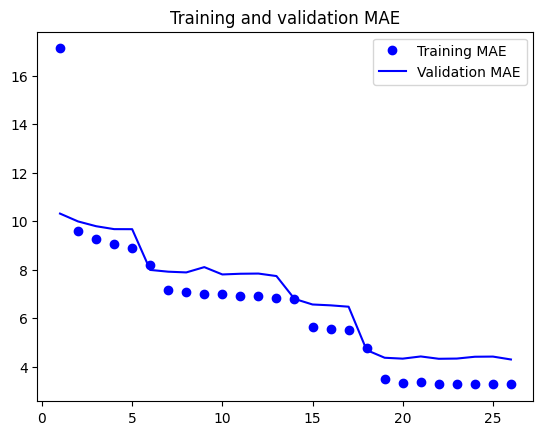

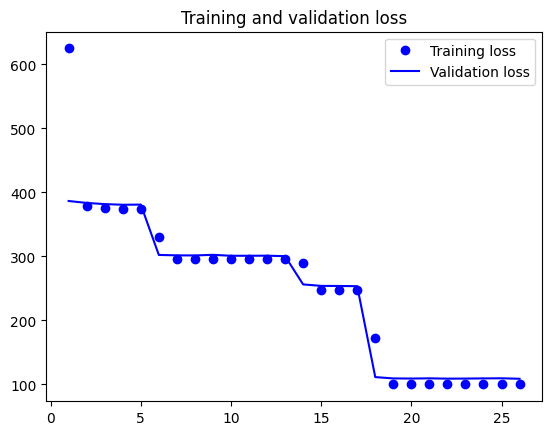

In [83]:
import matplotlib.pyplot as plt
mae = history.history["mae"]
val_mae = history.history["val_mae"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, "bo", label="Training MAE")
plt.plot(epochs, val_mae, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [66]:
images = preprocess_input(landmarks_frame_train)
points = preprocess_output(landmarks_frame_train)

In [84]:
inputs = keras.Input(shape=(96, 96, 1))
x = layers.Rescaling(1./255)(inputs) #skalowanie danych "w modelu"
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x) # "spłaszczanie" wektora przed przekazaniem do warswty gęstej

outputs = layers.Dense(30, activation="relu")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callback = [
    keras.callbacks.EarlyStopping(
        monitor="mae",
        patience=2, #zatrzymaj trenowanie jeśli model nie poprawił wyniku przez 3 epoki (czekaj 2 epoki)
    ),
]

model.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mae"],
              )
model.fit(
    images, 
    points, 
    epochs=50, 
    batch_size=16, 
    callbacks=callback,
)

results = model.evaluate(test_images, test_points)

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 829.7788 - mae: 21.1449
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 163.3910 - mae: 5.2349
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 160.8783 - mae: 4.8868
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 158.1163 - mae: 4.6235
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 157.0629 - mae: 4.4076
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 157.0603 - mae: 4.3343
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 155.9927 - mae: 4.2317
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 155.7723 - mae: 4.1829
Epoch 9/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 155.9623 - mae: 4.1306
Epoch 10/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 155.1408 - mae: 4.1099
Epoch 11/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 155.3474 - mae: 4.0653
Epoch 12/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 155.4964 - mae: 4.1059


In [85]:
predictions = model.predict(test_images[0:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


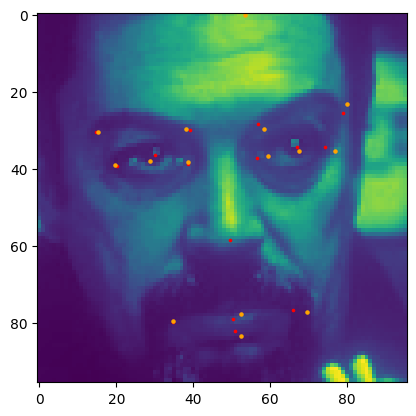

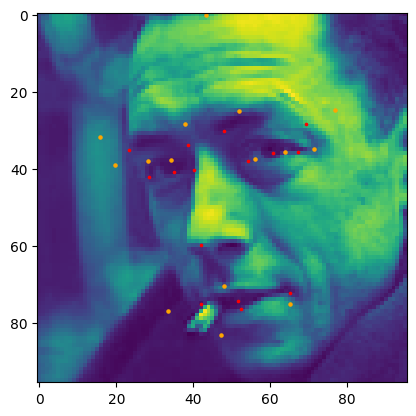

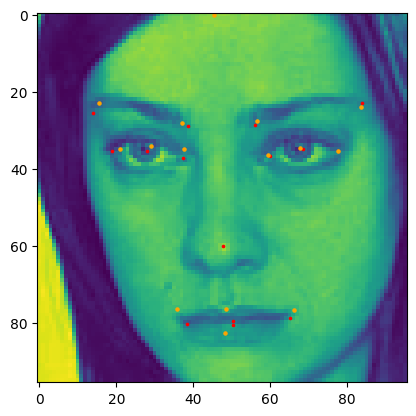

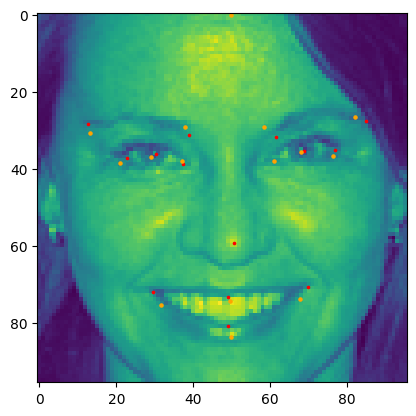

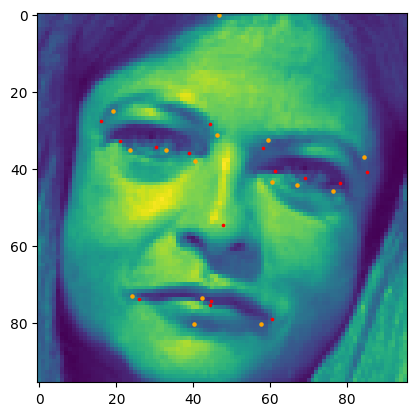

In [86]:
for i, pred in enumerate(predictions):
  show_landmarks(test_images[i], test_points[i], pred)